# xVal demo

In this notebook, we demonstrate the methodology of xVal on a dataset generated by simulating planetary orbits where each line is a string containing a dict. 

## 0. Load dependencies

In [1]:
### Huggingface dataset and tokenizer imports
from datasets import Dataset
from transformers import PreTrainedTokenizerFast

# ### xVal imports
from xval import make_tokenizer, preprocess, analyze

## 1. Peek at the structure of the input data

We will use a simulated dataset of planets orbiting a central mass generated using [REBOUND](https://rebound.readthedocs.io/en/latest/). To follow along, you can download the dataset from [here](https://drive.google.com/file/d/1OZKyBQ2Z12-Vk7NLcS482yM-RZi9T_FG/view?usp=sharing). 

To generate a file with N (where N is an int) more samples for the dataset, run python draw_sample.py N inside the planets-sim folder. You need the rebound package installed to run this command.

Load the dataset (using HuggingFace's datasets library):

In [2]:
data_dir = './data'

ds = Dataset.from_text(data_dir+'/test')
ds

Dataset({
    features: ['text'],
    num_rows: 125000
})

Look at the first several numbers of the first entry:

In [3]:
entry = 0 # index for each row in the dataset
n_characters = 200 # number of characters to show from each row
ds['text'][entry][:n_characters]

"{'description':{'planet0':{'m':1.3125619386712204,'a':1.944262696822503,'e':1.89780665411419},'planet1':{'m':3.244713929420367,'a':1.0,'e':0.030532756300304165},'planet2':{'m':2.4168466259605887,'a':2"

## 2. Tokenize 
### (Including demo of command line preprocessing function)

In 2a, we provide an explanation of the low level functions defined in this package.<br> 
In 2b, we provide a high level command-line function that preprocesses the data and saves it to disk.

### 2a. Intuitive explanation

#### 2a.1 Building a tokenizer

We build a tokenizer such that all the keys of the json structure are individual tokens. For this purpose we first need to extract all the keys from the json structure. 

We then construct a HuggingFace tokenizer and save it to disk.

In [4]:
# Extracting all the keys
ds_keys = ds.map(
    lambda x: {"keys": preprocess.extract_all_keys(x["text"])},
    num_proc=30,
    remove_columns=["text"],
    load_from_cache_file=False,
)
sample_keys = list(set([item for sublist in ds_keys["keys"] for item in sublist]))
print(f"\nExtracted keys from dataset:  {sample_keys}\n")

# Building a tokenizer with the extracted keys as individual tokens.
make_tokenizer.make_tokenizer(
    save_file="./tokenizer.json", efficient_json=True, sample_keys=sample_keys
)

Map (num_proc=30):   0%|          | 0/125000 [00:00<?, ? examples/s]


Extracted keys from dataset:  ['e', 'planet4', 'description', 'data', 'a', 'm', 'planet3', 'stepsize', 'planet1', 'planet2', 'planet0']



Now we can load the tokenizer using the HuggingFace tokenizer defintions.<br>
Note that the saved tokenizer does not know about the special tokens, so we indicate them manually.

In [5]:
tokenizer = PreTrainedTokenizerFast(
    tokenizer_file="./tokenizer.json",
    bos_token="[END]", # beginning of sentence
    eos_token="[END]", # end of sentence
    mask_token="[MASK]", # mask token
    pad_token="[PAD]", # pad token
)

#### 2a.2 Converting the data to xVal tokenized format

Here, we first look at tokenizing an individual sample and then apply it to the entire dataset using HuuggingFace's map function.

Let's take a string from the test file:

In [6]:
print(ds['text'][0][:100])

{'description':{'planet0':{'m':1.3125619386712204,'a':1.944262696822503,'e':1.89780665411419},'plane


We first need to convert numbers into a specific scientific notation to facilitate numerical extraction:<br>
(This step is also useful for using other numerical encoding schemes such as those included in the xVal paper.)

In [7]:
x = preprocess.convert_num_string(ds['text'][0][:100], sigfigs=3)
print(x)

{'description':{'planet0':{'m':+1.31e+0,'a':+1.94e+0,'e':+1.90e+0},'plane


Then we can apply our tokenizer. The tokenize_fnc function combines the number conversion and the tokenization.

In [8]:
tokenized_x = preprocess.tokenize_fnc(ds['text'][0][:100], tokenizer)

print('input_ids:', tokenized_x['input_ids'])
print('numbers:', tokenized_x['numbers'])

input_ids: [4, 18, 4, 26, 4, 21, 3, 8, 20, 3, 8, 16, 3, 5, 8]
numbers: [1.     1.     1.     1.     1.     1.     1.3125 1.     1.     1.944
 1.     1.     1.897  1.     1.    ]


Now that we have the hang of it, we can apply this to the whole dataset. 

In [9]:
print("\nStarting tokenization...")
tokenize_lambda = lambda x: preprocess.tokenize_fnc(x, tokenizer)
tokenized_ds = ds.map(
    tokenize_lambda,
    batched=False,
    num_proc=30,
    remove_columns=["text"],
    load_from_cache_file=False,
)


Starting tokenization...


Map (num_proc=30):   0%|          | 0/125000 [00:00<?, ? examples/s]

Let's inspect the first few tokens of the tokenized dataset. Note that the tokenized dataset contains `input_ids`, corresponding to the index of the token, and `numbers`, containing the actual numerical values associated with all `[NUM]` tokens. 

By the way, which index corresponds to the `[NUM]` token? You can inspect this yourself by looking at the `tokenizer.json` file, or you can test it directly: 

In [10]:
num_token = tokenizer.encode("[NUM]")[0]
print(f"[NUM] --> token #{num_token}")

[NUM] --> token #3


In [11]:
# The column "len" is used to calculate the maximum length of the input sequence.
tokenized_ds

Dataset({
    features: ['input_ids', 'numbers', 'len'],
    num_rows: 125000
})

Note that in the two lines below, the `numbers` are 1 except for when they correspond to a `[NUM]` token: 

In [12]:
x_token_ids = tokenized_ds[entry]['input_ids'][:10]
x_token_ids

[4, 18, 4, 26, 4, 21, 3, 8, 20, 3]

In [13]:
x_num = tokenized_ds[entry]['numbers'][:10]
x_num

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.3125, 1.0, 1.0, 1.944]

What do these strings of numbers mean? Let's decode them...

In [14]:
[tokenizer.decode(x) for x in x_token_ids]

['{',
 "'description':",
 '{',
 "'planet0':",
 '{',
 "'m':",
 '[NUM]',
 ',',
 "'a':",
 '[NUM]']

The above comparison is conveniently packaged in the token_structure function of the xVal package.<br>
This function provides a list of the tokens, along with their associated text and numerical values.

In [15]:
analyze.token_structure(tokenized_ds[entry], tokenizer)

{'description':{'planet0':{'m':[NUM],'a':[NUM],'e':[NUM]},'planet1':{'m':[NUM],'a':[NUM],'e':[NUM]},'planet2':{'m':

0,[4],{,1   1,[18],'description':,1   2,[4],{,1   3,[26],'planet0':,1   4,[4],{,1
5,[21],'m':,1   6,[3],[NUM],1.3   7,[8],,,1   8,[20],'a':,1   9,[3],[NUM],1.9
10,[8],,,1   11,[16],'e':,1   12,[3],[NUM],1.9   13,[5],},1   14,[8],,,1
15,[24],'planet1':,1   16,[4],{,1   17,[21],'m':,1   18,[3],[NUM],3.2   19,[8],,,1
20,[20],'a':,1   21,[3],[NUM],1   22,[8],,,1   23,[16],'e':,1   24,[3],[NUM],0.031
25,[5],},1   26,[8],,,1   27,[25],'planet2':,1   28,[4],{,1   29,[21],'m':,1


As expected, the numerical values have all been extracted, safely stored in the `x_num` list, and then replaced with a `[NUM]` token.

### 2b. Command-line tool

We will run the tokenization for `xVal` as well as `P10`, which encodes each digit of the number separately. 

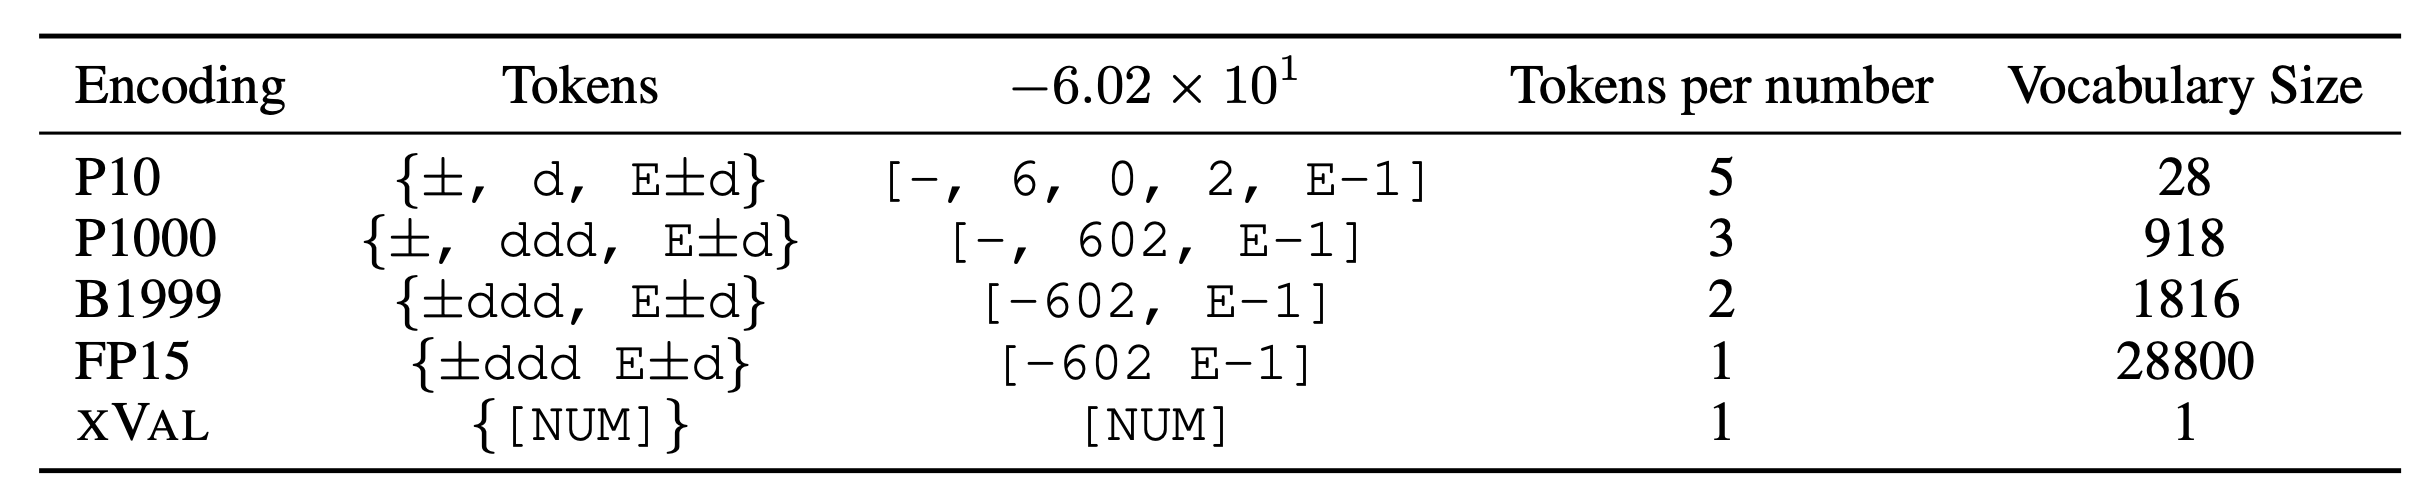

While you can use the cells below to run these in the notebook directly, it takes a few minutes to run, and the progress bars may not display correctly. We highly recommend running them in a separate terminal window with the following commands:

```sh
> data_dir=./data/
> python tokenize-dataset.py --datapath $data_dir --savepath $data_dir --encoding xval
> python tokenize-dataset.py --datapath $data_dir --savepath $data_dir --encoding p10
```

In [ ]:
# %run tokenize-dataset.py --datapath $data_dir --savepath $data_dir --encoding xval

In [ ]:
# %run tokenize-dataset.py --datapath $data_dir --savepath $data_dir --encoding fp15

## 3. Train

Here we train a toy model on the tokenized dataset.

In [30]:
import torch
from torch import optim
from datasets import DatasetDict
from torch.utils.data import DataLoader
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Where the model and collator is defined
from xval import numformer

In [28]:
### Define model
# The vocab_size is the number of different tokens in the tokenizer.
# context length is the maximum sequence size. 
model = numformer.Numformer(vocab_size=27, nhead=3, num_layers=3, d_model=384,  dim_feedforward=1536, context_length=955).cuda()
lr = 1e-4
weight_decay = 0.01
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

### Load the tokenizer 
tokenizer_path = "./tokenizer.json"
tokenizer = PreTrainedTokenizerFast(
    tokenizer_file=tokenizer_path,
    bos_token="[END]",
    eos_token="[END]",
    mask_token="[MASK]",
    pad_token="[PAD]",
)
pad_token_id = tokenizer.pad_token_id
num_token_id = tokenizer.convert_tokens_to_ids("[NUM]")
mask_token_id = tokenizer.mask_token_id
mlm_probability = 0.3
epochs = 10

### Load tokenized datasets 
dataset_path = "./data/tokenized_ds_xval"
tokenized_ds = DatasetDict.load_from_disk(dataset_path)

# Define the masked xVal collator which takes samples of unequal length and masks out both the token_ids and the numbers.
collator = numformer.define_masked_num_collator(pad_token_id, mask_token_id, mlm_probability)

train_loader = DataLoader(
    tokenized_ds["train"],
    batch_size=32,
    shuffle=True,
    collate_fn=collator,
)

In [29]:
### Run training loop

loss_hist = []
loss_mlm_hist = []
loss_num_hist = []

max_n_batches = 100 # without capping the number of batches, training takes many hours

try: 
    for e in tqdm(range(epochs)):
        n_batches = 0
        for batch in train_loader:
            if n_batches > max_n_batches: 
                break
            logit_preds, num_preds = model(batch["x"].cuda(), batch["x_num"].cuda())
            with torch.autocast(device_type="cuda"):
                loss_mlm = F.cross_entropy(
                    logit_preds.view(-1, logit_preds.size(-1)),
                    batch["y"].cuda().view(-1),
                    ignore_index=-100,
                    reduction="mean",
                )
                num_mask = batch['y']==num_token_id
                loss_num = F.mse_loss(
                    num_preds[num_mask],
                    batch["y_num"][num_mask].view(-1,1).cuda(),
                    reduction="mean",
                )
            loss = loss_mlm + loss_num
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_hist.append(loss.item())
            loss_mlm_hist.append(loss_mlm.item())
            loss_num_hist.append(loss_num.item())
            n_batches += 1 

            # calculate the running average of the losses
            try:
                loss_avg = 0.99*loss_avg + 0.01*loss.item()
                loss_mlm_avg = 0.99*loss_mlm_avg + 0.01*loss_mlm.item()
                loss_num_avg = 0.99*loss_num_avg + 0.01*loss_num.item()
            except:
                loss_avg = loss.item()
                loss_mlm_avg = loss_mlm.item()
                loss_num_avg = loss_num.item()
        
        ### Save checkpoint at each epoch
        checkpoint = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "loss": loss_avg,
                "loss_hist": loss_hist,
                "loss_mlm_hist": loss_mlm_hist,
                "loss_num_hist": loss_num_hist,
            }
        torch.save(checkpoint, "./ckpt.pt")
        print(f"Epoch #{e}: loss_mlm = {loss_mlm_avg:.3f}; loss_num = {loss_num_avg:.3f}; loss_total = {loss_avg:.3f}")
except KeyboardInterrupt:
    print('Interrupted')

 10%|█         | 1/10 [00:17<02:37, 17.54s/it]

Epoch #0: loss_mlm = 1.776; loss_num = 1.505; loss_total = 3.282


 20%|██        | 2/10 [00:35<02:21, 17.70s/it]

Epoch #1: loss_mlm = 0.868; loss_num = 1.468; loss_total = 2.336


 30%|███       | 3/10 [00:53<02:05, 17.90s/it]

Epoch #2: loss_mlm = 0.455; loss_num = 1.454; loss_total = 1.909


 40%|████      | 4/10 [01:11<01:47, 17.88s/it]

Epoch #3: loss_mlm = 0.284; loss_num = 1.433; loss_total = 1.717


 50%|█████     | 5/10 [01:29<01:29, 17.84s/it]

Epoch #4: loss_mlm = 0.214; loss_num = 1.428; loss_total = 1.642


 60%|██████    | 6/10 [01:46<01:11, 17.81s/it]

Epoch #5: loss_mlm = 0.204; loss_num = 1.433; loss_total = 1.637


 70%|███████   | 7/10 [02:04<00:53, 17.85s/it]

Epoch #6: loss_mlm = 0.172; loss_num = 1.435; loss_total = 1.607


 80%|████████  | 8/10 [02:22<00:35, 17.88s/it]

Epoch #7: loss_mlm = 0.158; loss_num = 1.418; loss_total = 1.576


 90%|█████████ | 9/10 [02:40<00:17, 17.89s/it]

Epoch #8: loss_mlm = 0.143; loss_num = 1.402; loss_total = 1.545


100%|██████████| 10/10 [02:58<00:00, 17.86s/it]

Epoch #9: loss_mlm = 0.131; loss_num = 1.374; loss_total = 1.505


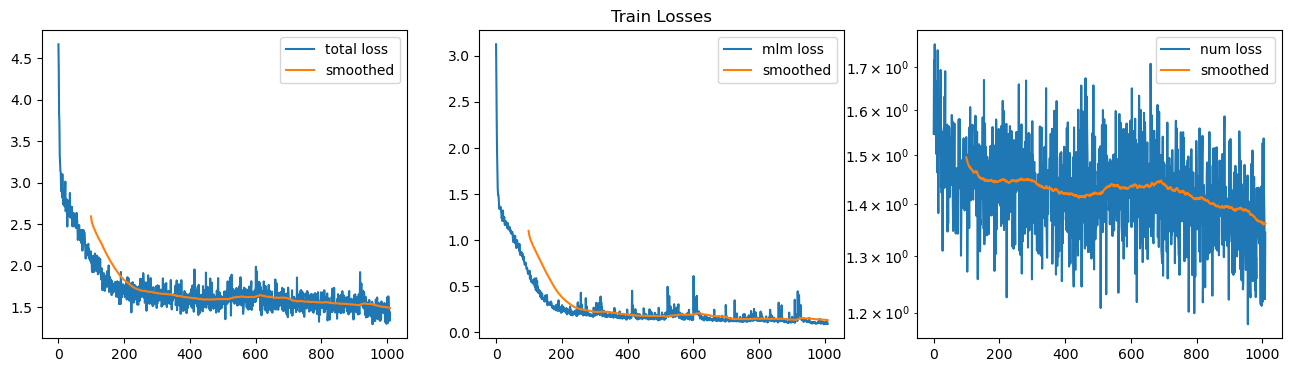

In [33]:
# plot with 3 subplots arranged horizontally
fig, ax = plt.subplots(1,3, figsize=(16,4))

ax[0].plot(loss_hist, label='total loss')
ax[0].plot(pd.Series(loss_hist).rolling(100).mean(), label='smoothed')
ax[0].legend()
ax[1].plot(loss_mlm_hist, label='mlm loss')
ax[1].plot(pd.Series(loss_mlm_hist).rolling(100).mean(), label='smoothed')
ax[1].legend()
ax[2].semilogy(loss_num_hist, label='num loss')
ax[2].semilogy(pd.Series(loss_num_hist).rolling(100).mean(), label='smoothed')
ax[2].legend()
ax[1].set_title('Train Losses');

## 4. Evaluate trained model

In [1]:
import torch
from datasets import DatasetDict
from xval import numformer, analyze
from transformers import PreTrainedTokenizerFast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Load tokenized test set:

In [2]:
dataset_path = "./data/tokenized_ds_xval"
tokenized_ds = DatasetDict.load_from_disk(dataset_path)

Load checkpoint:

In [10]:
checkpoint = torch.load("./ckpt_longer.pt")
model = numformer.Numformer(vocab_size=100).cuda()
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [11]:
### Load the tokenizer 
tokenizer_path = "./tokenizer.json"
tokenizer = PreTrainedTokenizerFast(
    tokenizer_file=tokenizer_path,
    bos_token="[END]",
    eos_token="[END]",
    mask_token="[MASK]",
    pad_token="[PAD]",
)

Try masking a number:

In [12]:
sample = tokenized_ds['test'][0]
device = 'cuda'

num_token = tokenizer.encode("[NUM]")[0]
# Look up all the locations where there are numbers
number_ids = np.where(np.array(sample['input_ids']) == num_token)[0] # indices that contain numbers

In [13]:
i = [number_ids[1]] # pick one
print("Masking number #{}: {:.4f}".format(i[0], sample['numbers'][i[0]]))
masked_sample = analyze.mask_numbers(sample, tokenizer, n_list=i)
out = analyze.predict(model, masked_sample, device)
print("Prediction: {:.4f}".format(out[1][:,i,:][0][0][0]))

Masking number #9: 1.9443
Prediction: 1.9428


Now run this on many queries at once: 

In [14]:
analyze.predict_numbers(model, sample, tokenizer, n_list=number_ids[:3], device='cuda', all_at_once=False)

{'num_pred_list': [2.9999163150787354, 1.9427977800369263, 1.8847997188568115],
 'num_true_list': [1.3125, 1.944, 1.897]}

In [26]:
dfs = []

num_samples = 100 #len(tokenized_ds['test'])

### Planet 0
df = analyze.slow_eval_numbers(model, tokenized_ds["test"], tokenizer, n_list=number_ids[:3], device='cuda', num_samples=num_samples, all_at_once=False);
df[['m0_pred','a0_pred','e0_pred']] = pd.DataFrame(df.num_pred_list.tolist(), index=df.index)
df[['m0_true','a0_true','e0_true']] = pd.DataFrame(df.num_true_list.tolist(), index=df.index)
df.drop(columns=['num_pred_list', 'num_true_list'], inplace=True)
dfs.append(df)

### Planet 1
df = analyze.slow_eval_numbers(model, tokenized_ds["test"], tokenizer, n_list=number_ids[3:6], device='cuda', num_samples=num_samples, all_at_once=False);
df[['m1_pred','a1_pred','e1_pred']] = pd.DataFrame(df.num_pred_list.tolist(), index=df.index)
df[['m1_true','a1_true','e1_true']] = pd.DataFrame(df.num_true_list.tolist(), index=df.index)
df.drop(columns=['num_pred_list', 'num_true_list'], inplace=True)
dfs.append(df)

### Planet 2
df = analyze.slow_eval_numbers(model, tokenized_ds["test"], tokenizer, n_list=number_ids[6:9], device='cuda', num_samples=num_samples, all_at_once=False);
df[['m2_pred','a2_pred','e2_pred']] = pd.DataFrame(df.num_pred_list.tolist(), index=df.index)
df[['m2_true','a2_true','e2_true']] = pd.DataFrame(df.num_true_list.tolist(), index=df.index)
df.drop(columns=['num_pred_list', 'num_true_list'], inplace=True)
dfs.append(df)

df = pd.concat(dfs, axis=1)

100%|██████████| 100/100 [00:04<00:00, 20.92it/s]


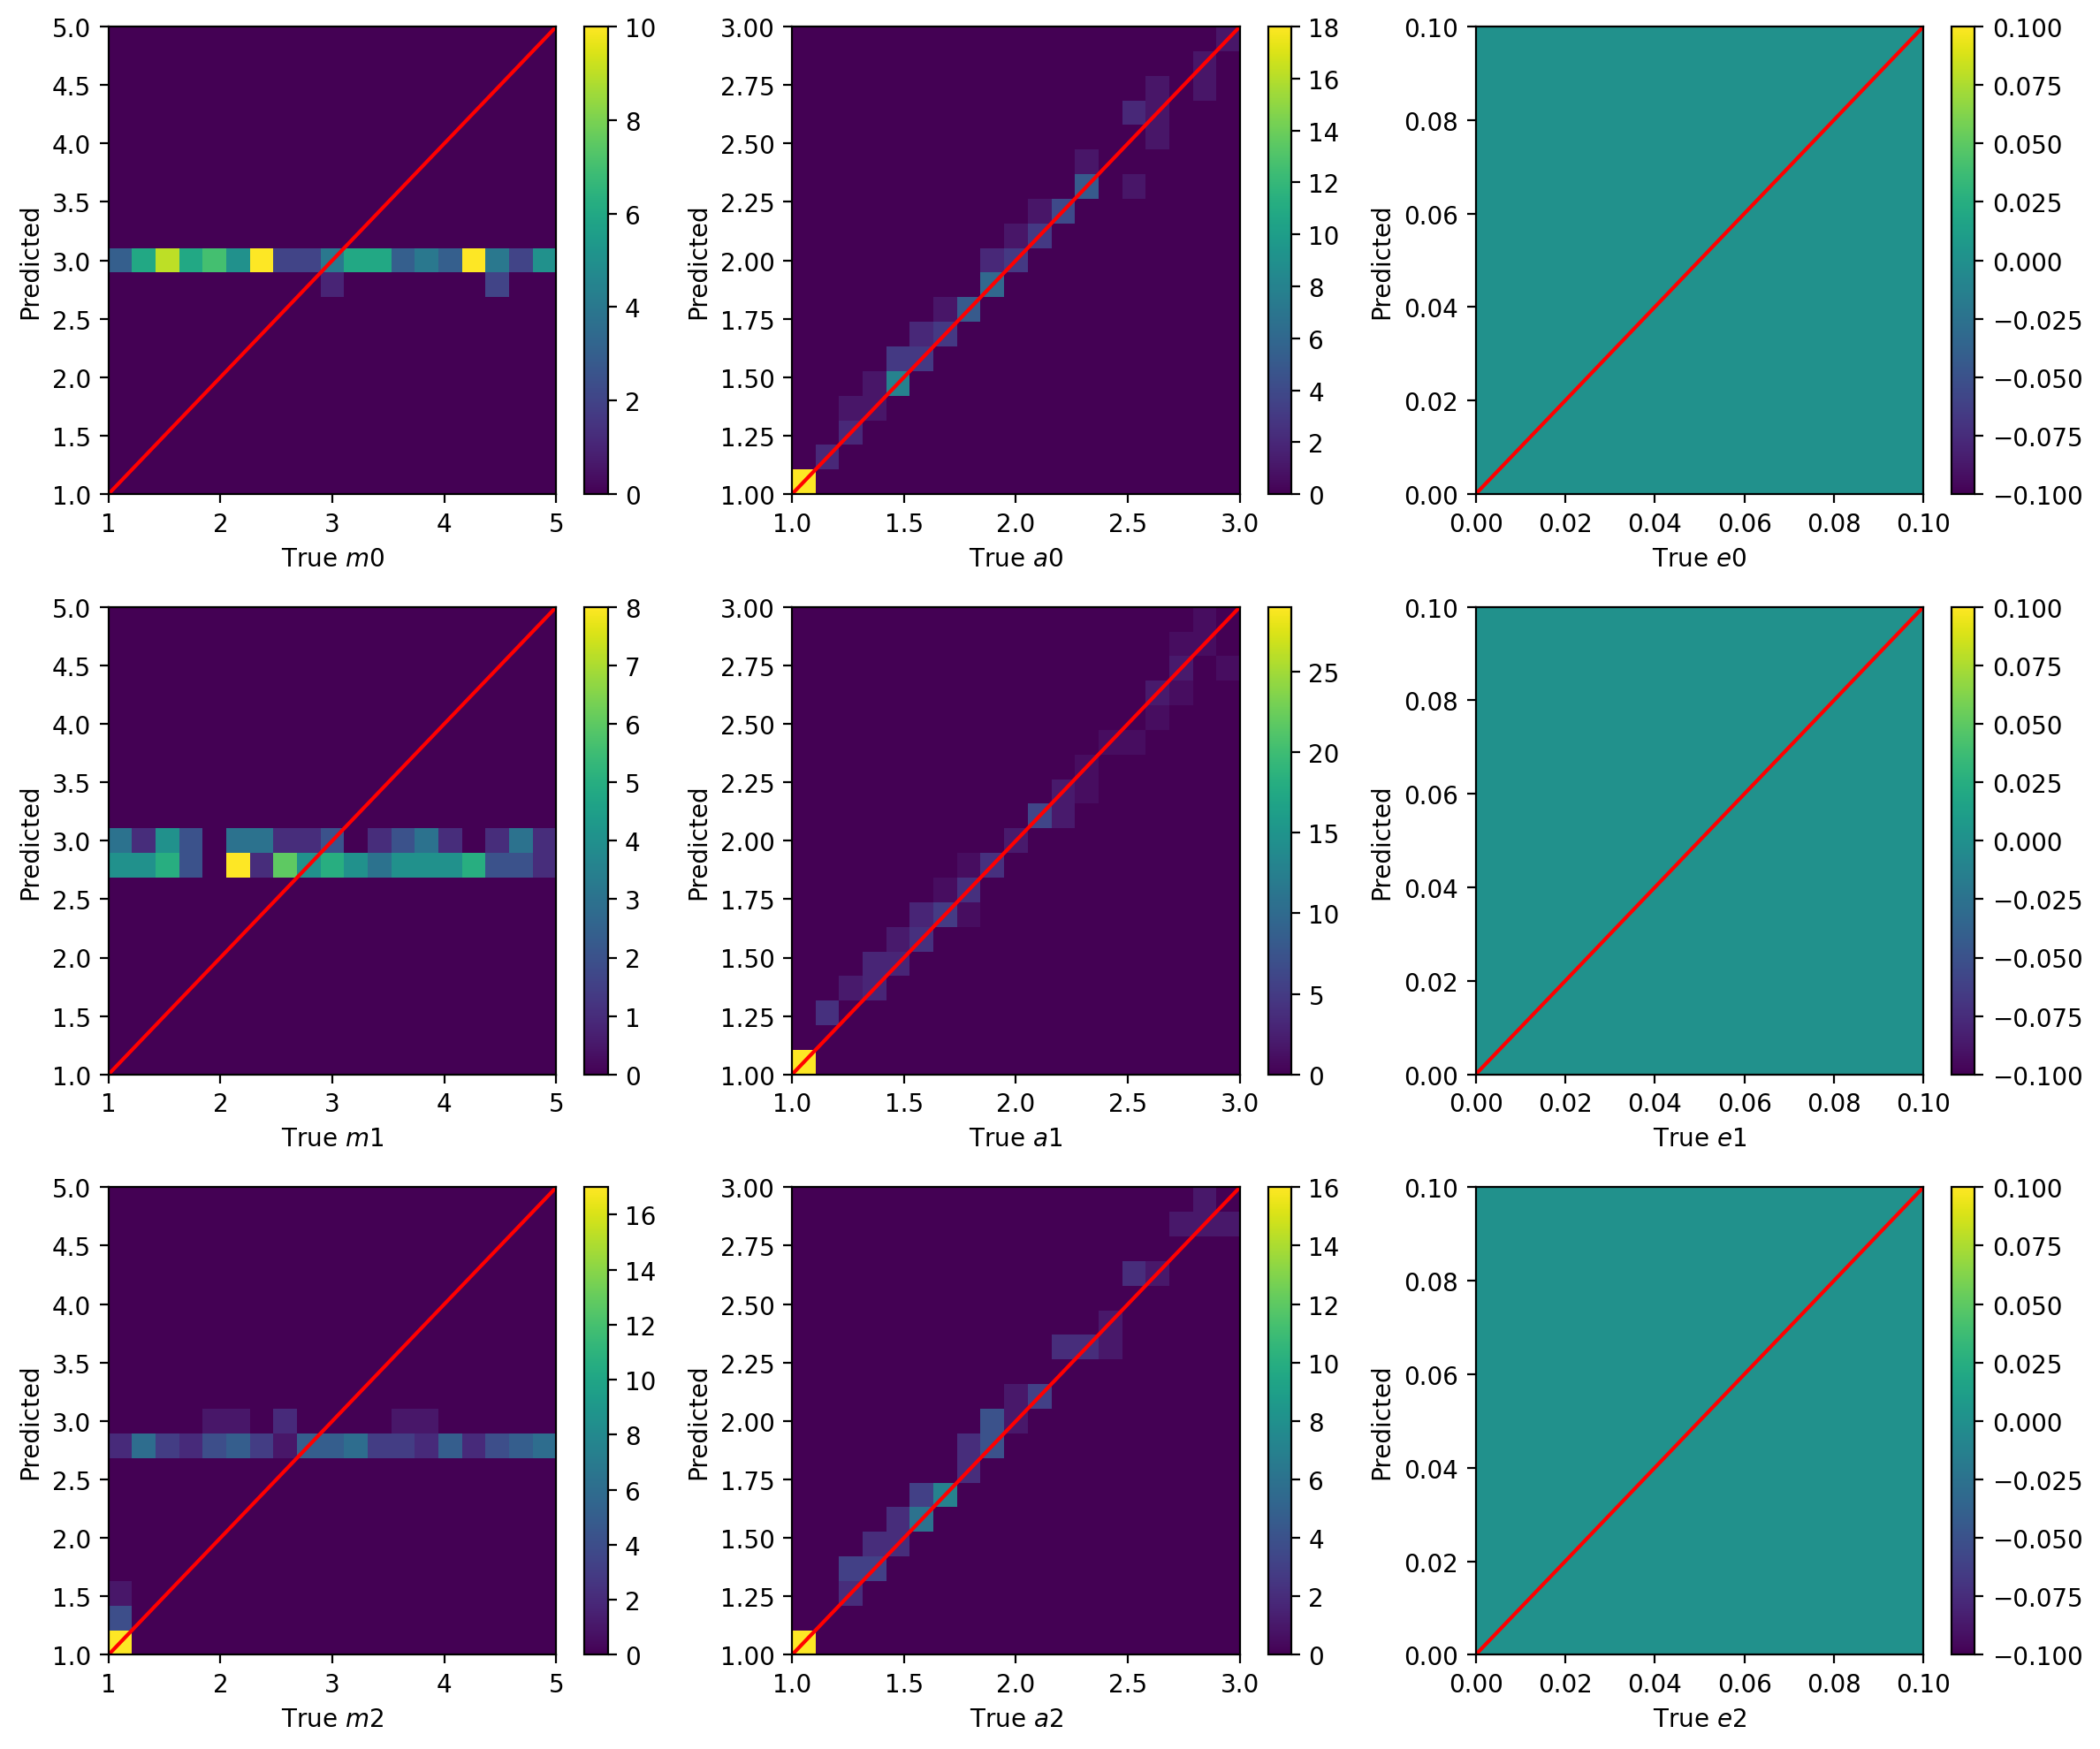

In [27]:
preds = df

total_bins = 20

var_list = ['m0', 'a0', 'e0', 'm1', 'a1', 'e1', 'm2', 'a2', 'e2']
m_bins = np.linspace(1,5,total_bins)
a_bins = np.linspace(1,3,total_bins)
e_bins = np.linspace(0,0.1,total_bins)

bins_list = [m_bins, a_bins, e_bins, m_bins, a_bins, e_bins, m_bins, a_bins, e_bins]

### LINEAR COMPARISON
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12,10), dpi=200, tight_layout=True)

for i in range(len(var_list)):
    if i < 3: 
        row = 0
    elif i < 6: 
        row = 1
    else: 
        row = 2
    ax = axs[row,i%3]
    var = var_list[i]
    xbins = bins_list[i]
    h = ax.hist2d(preds[var+'_true'], preds[var+'_pred'], bins = (xbins,xbins))
    ax.plot(xbins, xbins, color='red');
    ax.set_xlabel("True ${}$".format(var))
    ax.set_ylabel("Predicted");
    fig.colorbar(h[3], ax=ax);

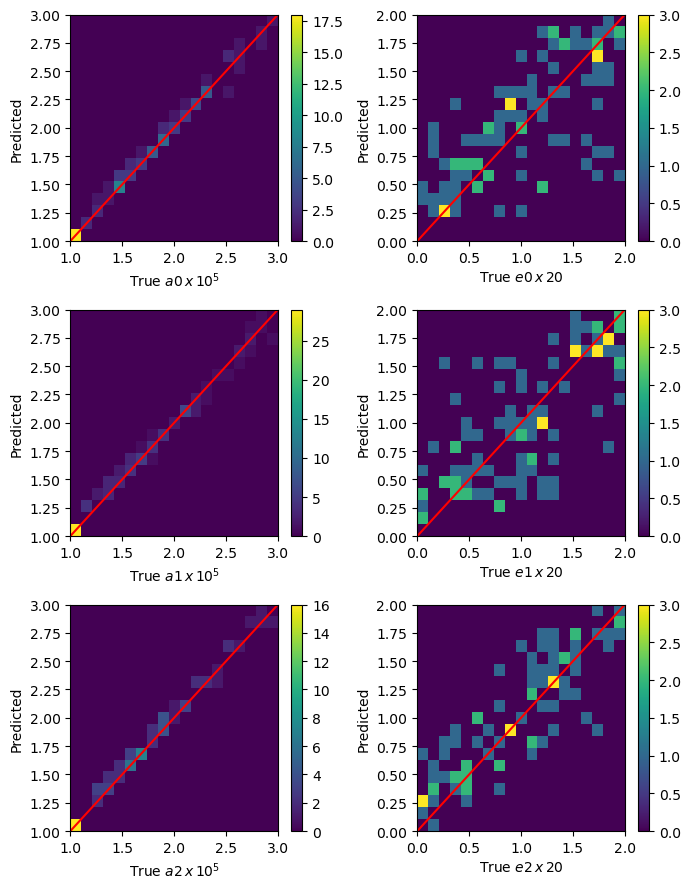

In [37]:
preds = df

total_bins = 20

var_list = ['a0', 'e0', 'a1', 'e1', 'a2', 'e2']
a_bins = np.linspace(1,3,total_bins)
e_bins = np.linspace(0,2.0,total_bins)

bins_list = [a_bins, e_bins, a_bins, e_bins, a_bins, e_bins]

### LINEAR COMPARISON
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(7,9),tight_layout=True)

for i in range(len(var_list)):
    if i < 2: 
        row = 0
    elif i < 4: 
        row = 1
    else: 
        row = 2
    ax = axs[row,i%2]
    var = var_list[i]
    xbins = bins_list[i]
    h = ax.hist2d(preds[var+'_true'], preds[var+'_pred'], bins = (xbins,xbins))
    ax.plot(xbins, xbins, color='red');
    ax.set_xlabel("True ${} \,x\, {}$".format(var, "10^5" if "a" in var else "20"))
    ax.set_ylabel("Predicted");
    fig.colorbar(h[3], ax=ax);